# SLT-CE-2: Histogram Clustering
STILL NOT HAVE DONE 4.5

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 (If you cannot access, you can try the same link after configuring your ETH VPN.)

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt23_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/lectures/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [26]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

## Texture and corresponding label map
(This texture is used to fit your model.)

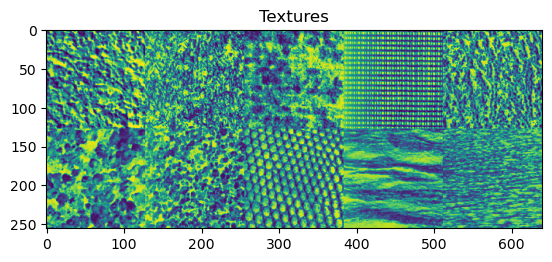

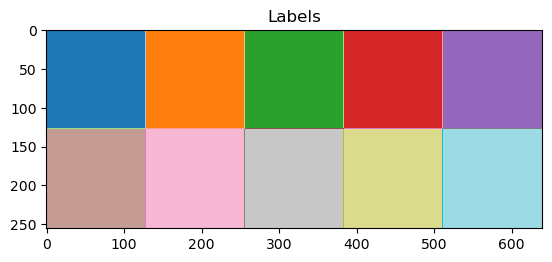

In [27]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

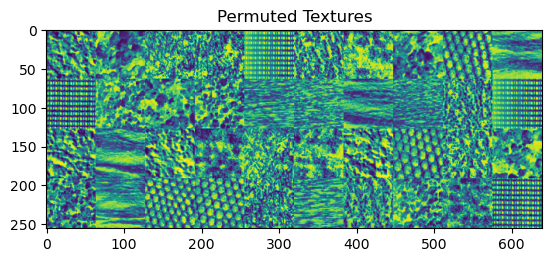

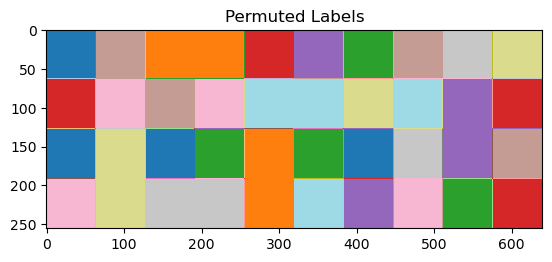

In [28]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.<br>
Hint 2: See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.
</p>

Put your recap here.

In the case of DA, equation (5) becomes $\hat{P}(y|c)=\dots$

## Maximum A Posteriori (MAP) Estimation

\begin{align}

    \hat{\mathbb{P}} (y|c) &= \sum_{x: \hat{c}(x) = c} \cfrac{n(x)}{\sum_{x': \hat{c}(x') = c} n(x')} \hat{\mathbb{P}} (y|x),\hspace{1em}\

\end{align}


## Deterministic Annealing (DA) Estimation

\begin{align}
    \hat{\mathbb{P}}(y\vert c) &= \cfrac{\sum_{x\in X} \hat{\mathbb{P}}(y\vert x)\cdot \mathbb{P}(c\vert x)}{\sum_{x\in X}  \mathbb{P}(c\vert x)} 
\end{align}

\begin{align}
    \hat{\mathbb{P}}(c|x) = \cfrac{\exp\left(-\frac{1}{T}D_{KL}(\hat{\mathbb{P}}(\cdot|x)\lVert\hat{\mathbb{P}}(\cdot|c))\right)}{\sum_{a} \exp\left(-\frac{1}{T}D_{KL}(\hat{\mathbb{P}}(\cdot|x)\lVert\hat{\mathbb{P}}(\cdot|c))\right)}
\end{align}


In [29]:
from sklearn.feature_extraction import image

class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)

    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).

    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """

    def __init__(self, n_clusters=10, n_bins=128, window_size=15, random_state=14504, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins =n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        self.DA_instability = 10e-6
        self.MAP_instability = 1e-6
        self.init_delta = 10000
        self.preds = []

    def histogram(self, area):
        h = np.histogram(area[area>-1], np.linspace(0, 1, self.n_bins + 1))[0]
        return h / np.sum(h)

    def create_hist(self, X):

        pad_wid= int((self.window_size-1)/2)
        padded_array = np.lib.pad(X, ((pad_wid,pad_wid),(pad_wid,pad_wid)), 'constant', constant_values=((-1, -1),(-1, -1)))
        patches = image.extract_patches_2d(padded_array, (self.window_size, self.window_size))
        return np.apply_along_axis(self.histogram, 1, np.reshape(patches, (np.prod(X.shape), -1)))

    def normalize_by_centroids(self, x, keepdims):
        if keepdims == True:
            return x / np.sum(self.centroids, axis=1, keepdims=True)
        else:
            return x / np.sum(self.centroids, axis=1)[:, np.newaxis]
        

    def fit(self, X):
        """Compute HC for input image X

        Compute centroids.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            self
        """
        np.random.seed(self.random_state)

        hists = self.create_hist(X)

        self.centroids = np.random.rand(self.n_clusters, self.n_bins)


        if self.estimation == "MAP":

            # self.centroids /= np.sum(self.centroids, axis=1, keepdims=True)
            self.centroids = self.normalize_by_centroids(self.centroids, True)


            predictions = np.argmax(hists @ np.log(self.centroids).T, 1)
            delta = self.init_delta
            while not delta == 0:
                for c in range(self.n_clusters):
                    indices = np.where(predictions == c)[0]
                    self.centroids[c] = np.mean(hists[indices], 0)
                    if self.centroids[c].any(0):
                      self.centroids[c] += self.MAP_instability

                new_predictions = np.argmax(hists @ np.log(self.centroids).T, 1)
                delta = np.sum(new_predictions - predictions)
                predictions = new_predictions

            # self.centroids /= np.sum(self.centroids, axis=1, keepdims=True)
            self.centroids = self.normalize_by_centroids(self.centroids, True)


        elif self.estimation == "DA":
          T = 0.25
          self.preds = []
        #   self.centroids /= np.sum(self.centroids, axis=1)[:, np.newaxis]
          self.centroids = self.normalize_by_centroids(self.centroids, False)

          p = np.ones((np.prod(X.shape), self.n_clusters)) / self.n_clusters

          while T >= 0.05:
              """
              for i in range(self.n_clusters):
                  for j in range(self.n_clusters):
                      if i != j and np.linalg.norm(self.centroids[i] - self.centroids[j]) < 0.0015:
                          self.centroids[j] += np.random.normal(scale=0.0015, size=self.centroids[j].shape)
                          self.centroids[j][self.centroids[j] < 0] *= -1
                          self.centroids[j][self.centroids[j] > 1] -= 1
              """
              mask = np.eye(self.n_clusters, dtype=bool)
              distances = np.linalg.norm(self.centroids[:, None] - self.centroids, axis=2)
              close_pairs = np.logical_and(distances < 0.0015, ~mask)

              for i, j in np.argwhere(close_pairs):
                  self.centroids[j] += np.random.normal(scale=0.0015, size=self.centroids[j].shape)
                  self.centroids[j] = np.clip(self.centroids[j], 0, 1)
                  self.centroids[j][self.centroids[j] < 0] *= -1

            #   self.centroids /= np.sum(self.centroids, axis=1)[:, np.newaxis]
              self.centroids = self.normalize_by_centroids(self.centroids, False)

              delta = self.init_delta
              while delta >= 2e-4:
                  log_ratios = [np.log(hists / (c + self.DA_instability) + self.DA_instability) for c in self.centroids]
                  p = np.exp((np.array([-np.sum(np.multiply(hists,ratio),axis=1) / T for ratio in log_ratios])))

                  p /= np.sum(p, axis=0)

                #   new = p @ hists / (np.sum(p.T, axis=0)[:, np.newaxis] * np.sum(self.centroids, axis=1)[:, np.newaxis])
                  new = p @ hists / (np.sum(p.T, axis=0)[:, np.newaxis])
                  new = self.normalize_by_centroids(new, False)

                  delta = np.linalg.norm(self.centroids - new)
                  self.centroids = new

              pred = self.predict(perm_texture, T=T)
              self.preds.append((T,pred))

              T = 0.9 * T


        return self


    def predict(self, X, T=0):
        """Predict cluster assignments for each pixel in image X.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            C (np.ndarray): Assignment map (height, width)
        """
        check_is_fitted(self, ["centroids"])
        # Your code goes here
        hists = self.create_hist(X)



        if self.estimation == "MAP":
            pred = np.argmax(hists @ np.log(self.centroids).T, 1)
            C = np.reshape(pred, X.shape)

        elif self.estimation == "DA":
            log_ratios = [np.log(hists / (c + self.DA_instability) + self.DA_instability) for c in self.centroids]
            p = np.exp((np.array([-np.sum(np.multiply(hists,ratio),axis=1) / T for ratio in log_ratios])))
            p /= np.sum(p, axis=0)
            args = np.argmax(p.T, 1)
            C = np.reshape(args, X.shape)

        return C

    def generate(self, C):
        """Generate a sample image X from a texture label map C.

        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).

        Args:
            C (np.ndarray): Input array with shape (height, width)

        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        X = np.ones(C.shape)
        bins = np.linspace(0, 1, self.n_bins + 1)

        random = np.random.random(size=C.shape)

        cumulative_sums = np.cumsum(self.centroids[C], axis=-1)

        bin_indices = np.argmax(random[:, :, None] < cumulative_sums, axis=-1)

        for h in range(patch_shape[0]):
            for w in range(patch_shape[1]):
                bin_idx = bin_indices[h, w]
                start = bins[bin_idx]
                end = bins[bin_idx + 1]
                X[h, w] = np.random.uniform(start, end)
        return X



<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [30]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

CPU times: user 11.2 s, sys: 1.94 s, total: 13.1 s
Wall time: 9.07 s


<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [31]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

CPU times: user 8.13 s, sys: 671 ms, total: 8.8 s
Wall time: 8.13 s


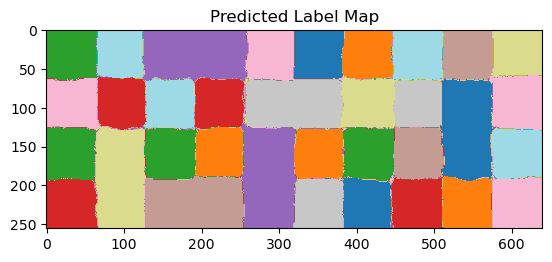

In [32]:
# Plot of predicted label map
plt.figure()
plt.title("Predicted Label Map")
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.show()

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

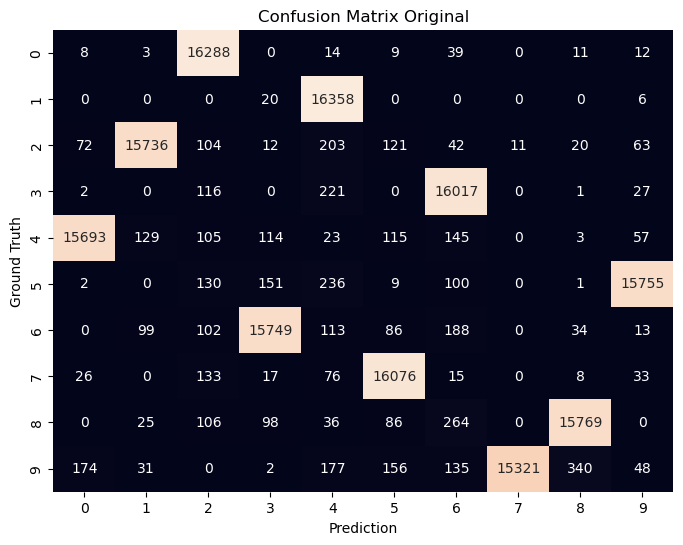

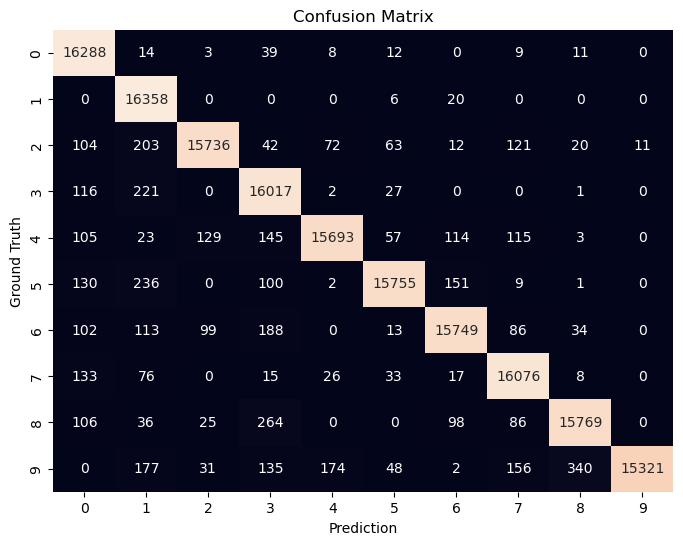

In [33]:
# Confusion matrix

import numpy as np
import seaborn as sns

import numpy as np

def correspondance(given_map, predict_map, count_clusters):
    given_flat = given_map.ravel()
    predict_flat = predict_map.ravel()
    shared_counts = np.zeros((count_clusters, count_clusters), dtype=int)
    for pred_cluster_id in range(count_clusters):
        for given_cluster_id in range(count_clusters):
            shared_indices = np.intersect1d(np.where(predict_flat == pred_cluster_id)[0],
                                            np.where(given_flat == given_cluster_id)[0])
            shared_counts[pred_cluster_id, given_cluster_id] = len(shared_indices)
    corr = {pred_cluster_id: np.argmax(shared_counts[pred_cluster_id]) for pred_cluster_id in range(count_clusters)}
    new_pred = np.vectorize(corr.get)(predict_flat)
    new_pred = new_pred.reshape(predict_map.shape)
    return new_pred, corr

corr = correspondance(perm_label_map, predicted_perm_label_map, 10)[0]

from sklearn.metrics import confusion_matrix, accuracy_score

y_true = np.ravel(perm_label_map)
pred_labels = np.ravel(predicted_perm_label_map)
conf_matrix = confusion_matrix(y_true, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix Original')
plt.show()


y_true = np.ravel(perm_label_map)
pred_labels = np.ravel(corr)
conf_matrix = confusion_matrix(y_true, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()


<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

In [34]:
bin_sizes = [16, 32, 64]
window_sizes = [7, 9, 11]
results = []

for bin_size in bin_sizes:
    for window_size in window_sizes:
        HC = HistogramClustering(n_bins=bin_size, window_size=window_size)
        HC.fit(texture)
        pred_perm_label_maps = HC.predict(perm_texture)
        accuracy = accuracy_score(np.ravel(perm_label_map), np.ravel(correspondance(perm_label_map, pred_perm_label_maps, count_clusters=10)[0]))
        results.append({'bin_size': bin_size, 'window_size': window_size, 'pred': pred_perm_label_maps, 'acc': accuracy})

/var/folders/qb/d4hwnh6j08gd2t6xyjf8s4j00000gn/T/ipykernel_49150/1122560498.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + bin_sizes)
/var/folders/qb/d4hwnh6j08gd2t6xyjf8s4j00000gn/T/ipykernel_49150/1122560498.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + window_sizes)


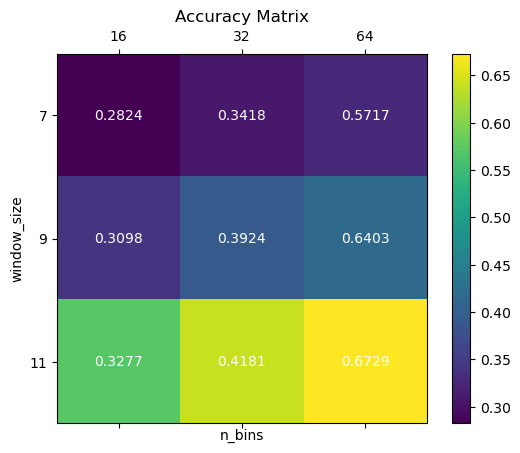

In [35]:
# 3x3 Matrix with accuracy scores of the different parameter combination

fig, ax = plt.subplots()

accuracies = [d['acc'] for d in results]
accuracy_matrix = np.array(accuracies).reshape(len(window_sizes), len(bin_sizes))

cax = ax.matshow(accuracy_matrix)
fig.colorbar(cax)

ax.set_xticklabels([''] + bin_sizes)
ax.set_yticklabels([''] + window_sizes)
ax.set_xlabel('n_bins')
ax.set_ylabel('window_size')
ax.set_title('Accuracy Matrix')

for i in range(len(window_sizes)):
    for j in range(len(bin_sizes)):
        ax.text(j, i, f'{accuracy_matrix[j,i]:.4f}', ha='center', va='center', color='white')

plt.show()


<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

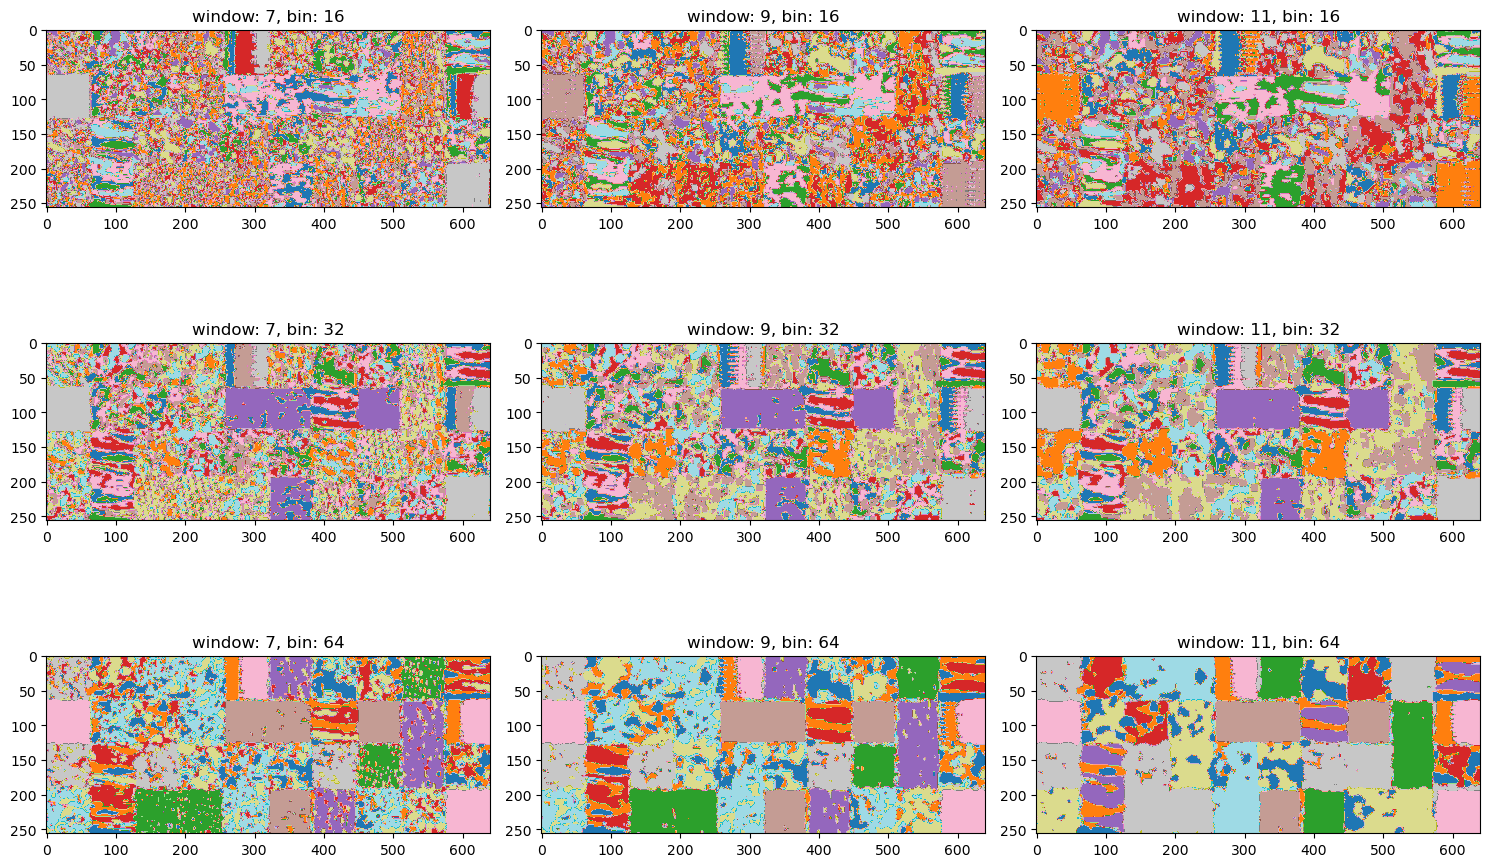

In [36]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
for i, dictionary in enumerate(results):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.imshow(dictionary["pred"], cmap="tab20")
    ax.set_title(f'window: {dictionary["window_size"]}, bin: {dictionary["bin_size"]}')

plt.tight_layout()
plt.show()


<h2 style="background-color:#f0b375;">
Section 5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

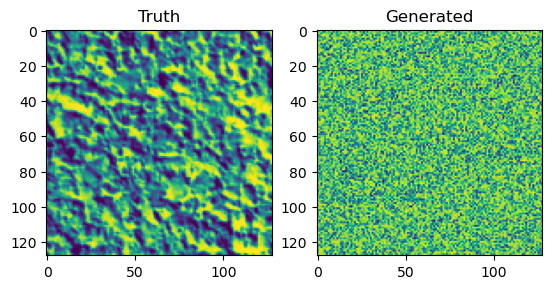

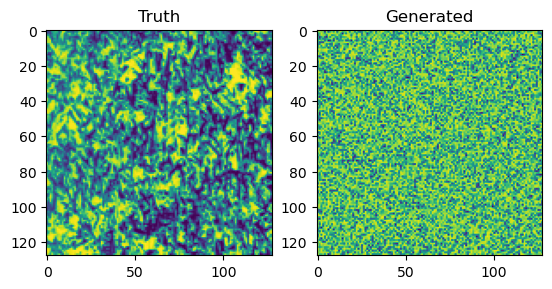

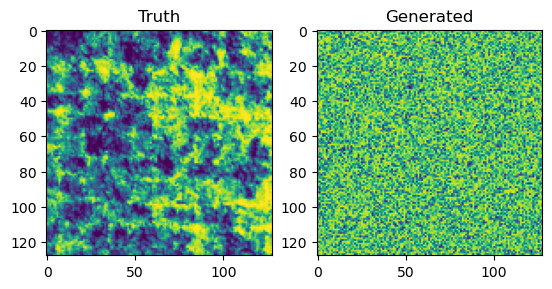

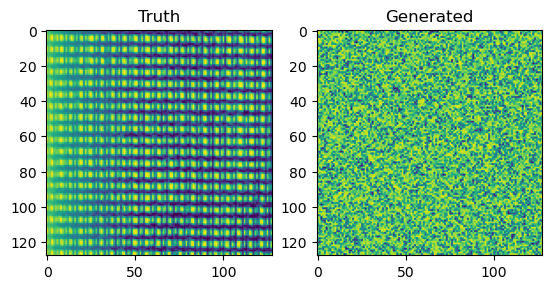

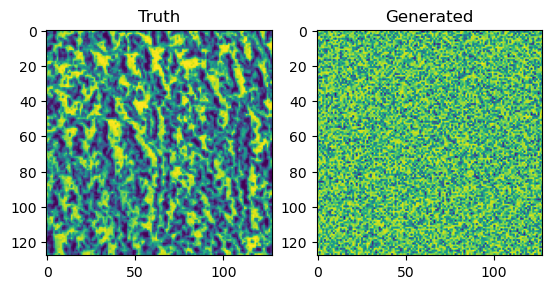

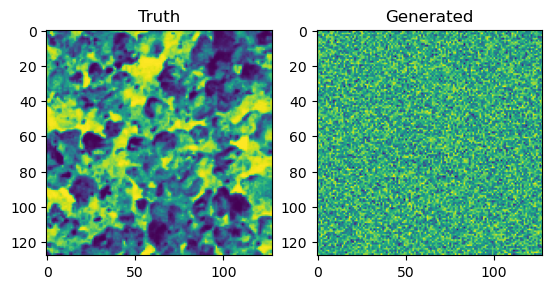

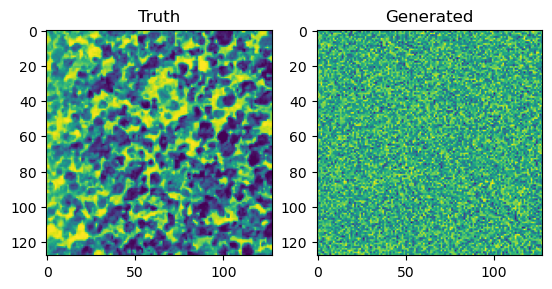

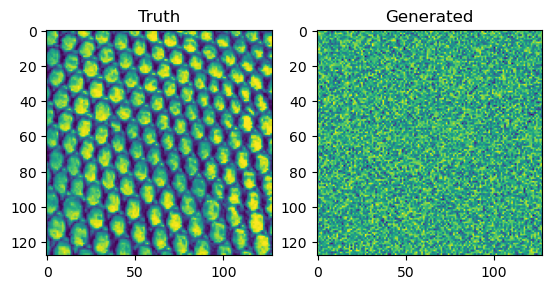

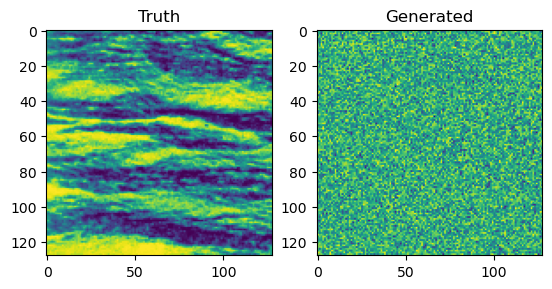

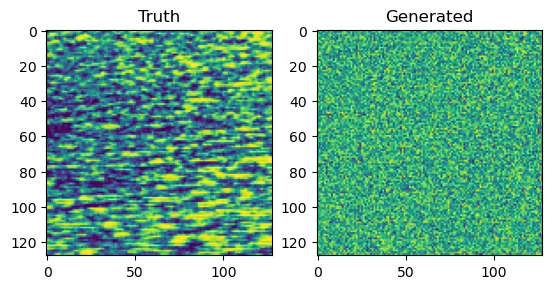

In [37]:
#C1 = np.ones(patch_shape) * 0
#X1 = HC.generate(C1)

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.

# Generated texture plot

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.
truth = []
gen = []

for i in range(patch_grid_shape[0]):
  for j in range(patch_grid_shape[1]):
    C = np.ones(patch_shape, dtype=int) * i
    gen.append(HC.generate(C))
    truth.append(texture[patch_shape[0] * i : patch_shape[0] * (i + 1), patch_shape[1] * j : patch_shape[1] * (j + 1)])


num_images = 10
num_cols = 2

for i in range(num_images):
    fig, axes = plt.subplots(1, num_cols)
    for j, (img, title) in enumerate(zip([truth[i], gen[i]], ['Truth', 'Generated'])):
        axes[j].imshow(img)
        axes[j].set_title(title)
    plt.show()


<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

/Users/marvin/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


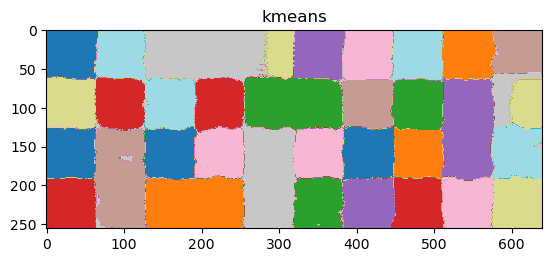

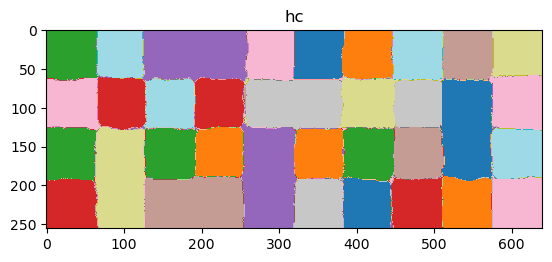

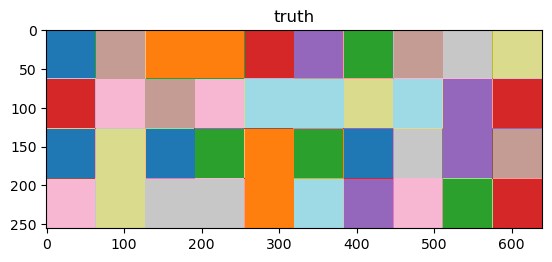

In [41]:
# Predicted label map for k-means
from sklearn.cluster import KMeans

hists = HC.create_hist(texture)
hists_test = HC.create_hist(perm_texture)

model = KMeans(n_clusters=10, max_iter=2000).fit(hists)
pred = model.predict(hists_test)
predicted_kmeans = np.reshape(pred, perm_label_map.shape)
corr_kmeans, mapping_kmeans = correspondance(perm_label_map, predicted_kmeans, 10)

# Predicted label map for HC

HC = HistogramClustering()
HC.fit(texture)
predicted_hc = HC.predict(perm_texture)
corr_hc, mapping_hc = correspondance(perm_label_map, predicted_hc, 10)

maps = {"kmeans":predicted_kmeans, "hc":predicted_hc, "truth":perm_label_map}

for name,map in maps.items():
  plt.figure()
  plt.imshow(map, cmap="tab20")
  plt.title(name)
  plt.show()

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

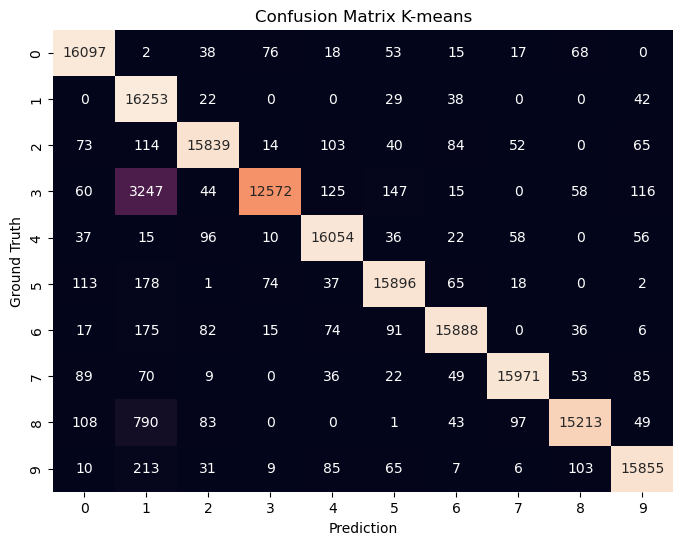

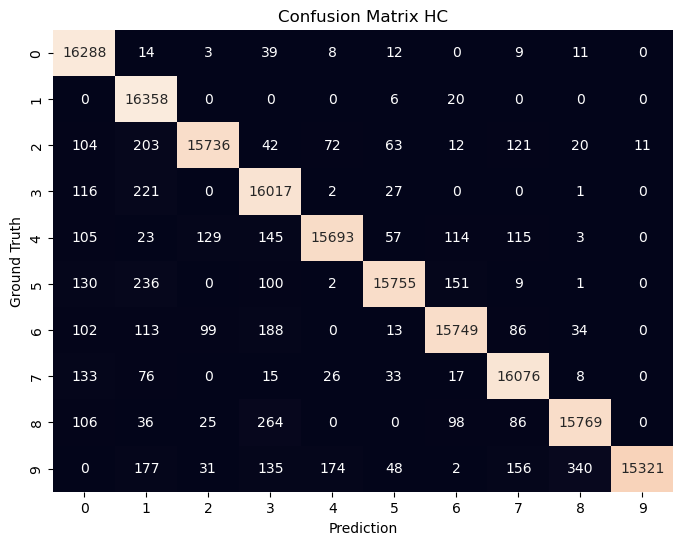

In [42]:
# Confusion matrices
y_true = np.ravel(perm_label_map)
y_kmeans = np.ravel(corr_kmeans)
y_hc = np.ravel(corr_hc)

conf_matrix = confusion_matrix(y_true, y_kmeans)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix K-means')
plt.show()

conf_matrix = confusion_matrix(y_true, y_hc)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix HC')
plt.show()


<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

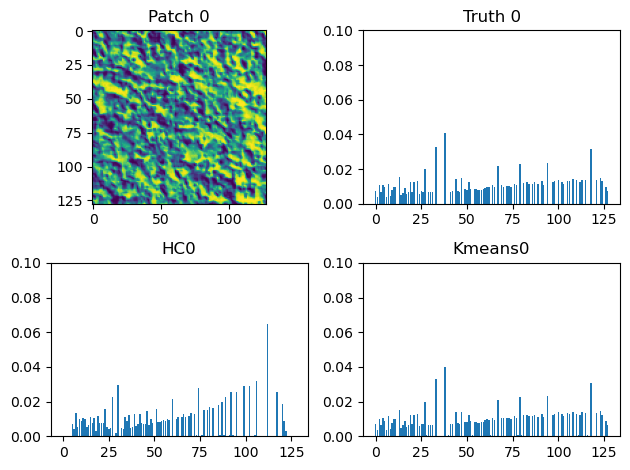

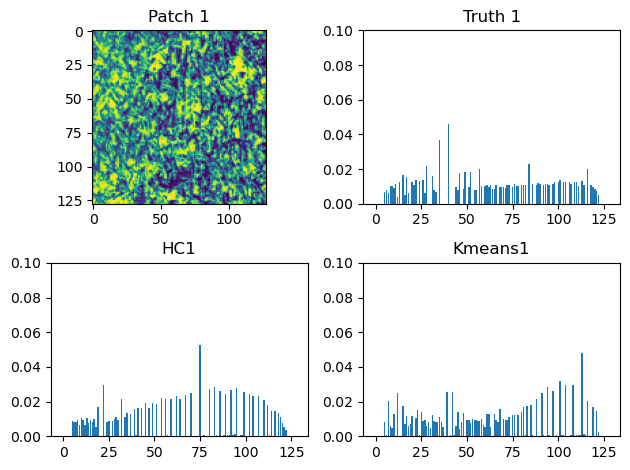

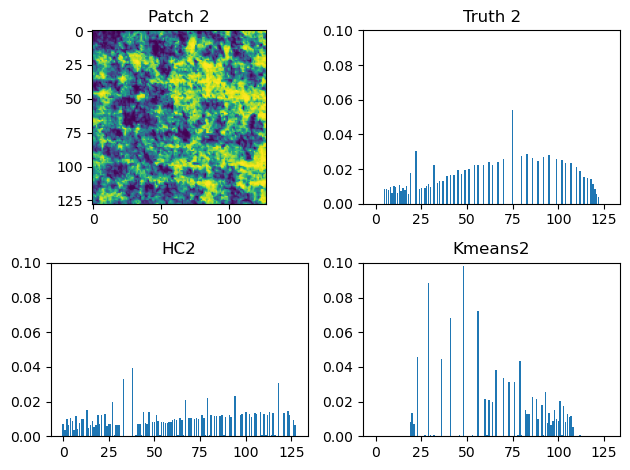

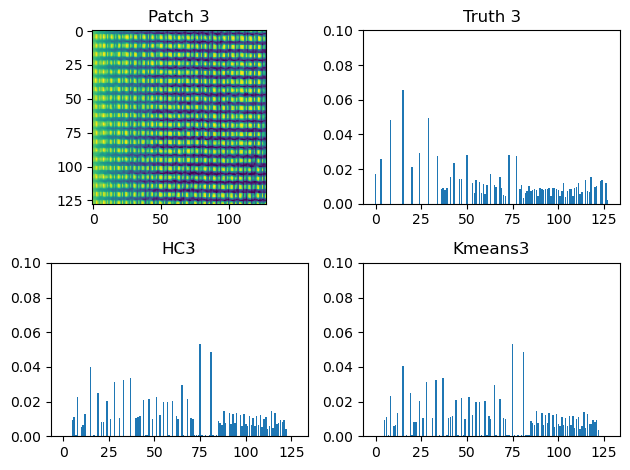

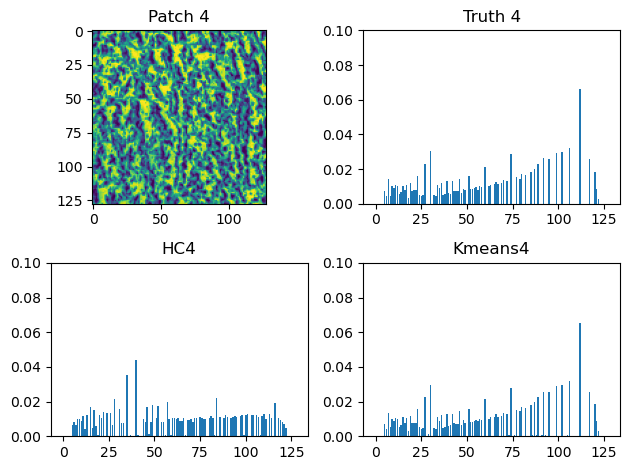

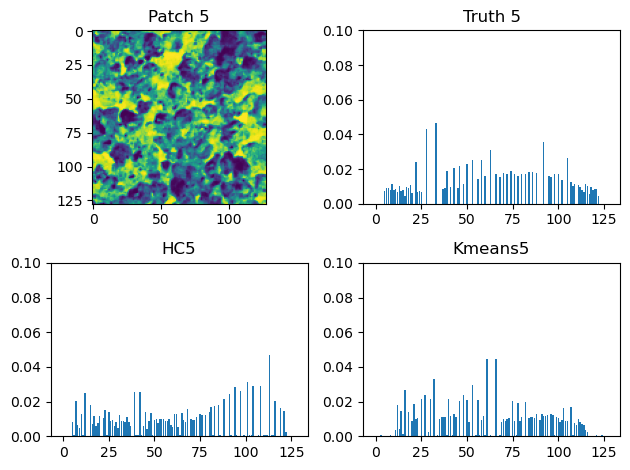

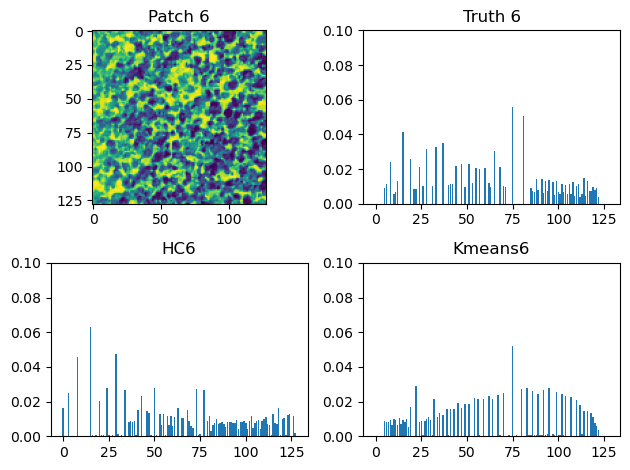

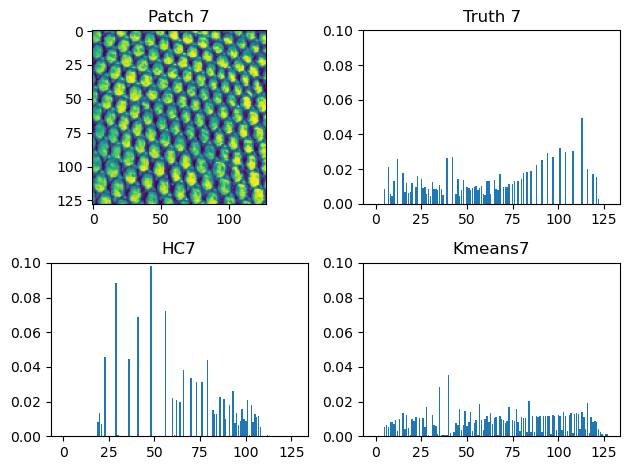

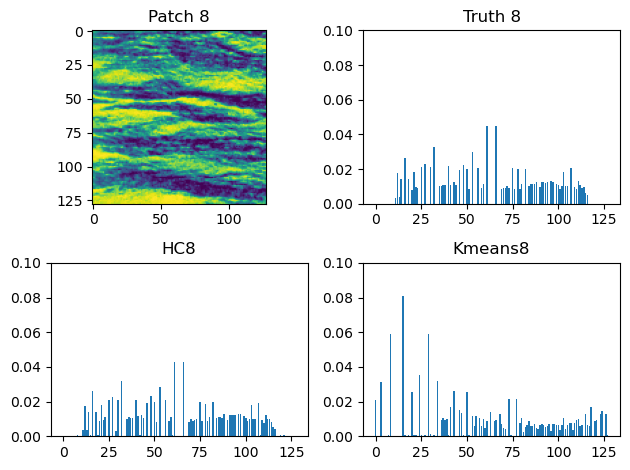

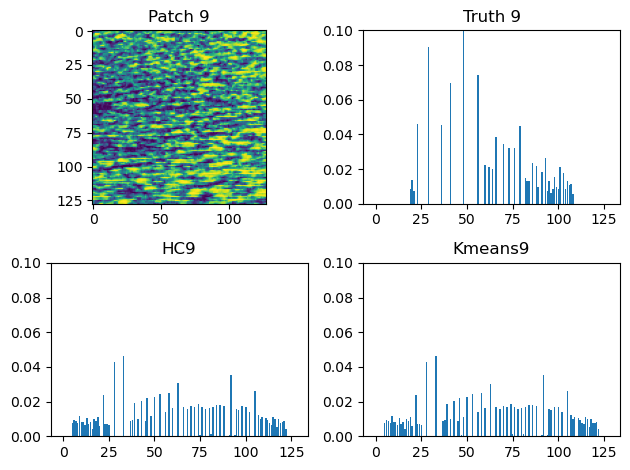

In [43]:
# Histograms
truths = []
for i in range(patch_grid_shape[0]):
    for j in range(patch_grid_shape[1]):
      index = i * patch_grid_shape[1] + j



      truth = texture[patch_shape[0] * i : patch_shape[0] * (i + 1), patch_shape[1] * j : patch_shape[1] * (j + 1)]

      org_hist = HC.histogram(truth)
      hc_hist = HC.centroids[list(mapping_hc.keys())[index]]
      km_hist = model.cluster_centers_[list(mapping_kmeans.keys())[index]]


      fig, axes = plt.subplots(2, 2)

      strindex = str(index)
      axes[0, 0].imshow(truth)
      axes[0, 0].set_title("Patch " + strindex)

      axes[0, 1].bar(range(0, HC.n_bins), org_hist)
      axes[0, 1].set_ylim((0, 0.1))
      axes[0, 1].set_title("Truth " + strindex)

      axes[1, 0].bar(range(0, HC.n_bins), hc_hist)
      axes[1, 0].set_ylim((0, 0.1))
      axes[1, 0].set_title("HC" + strindex)

      axes[1, 1].bar(range(0, HC.n_bins), km_hist)
      axes[1, 1].set_ylim((0, 0.1))
      axes[1, 1].set_title("Kmeans" + strindex)

      plt.tight_layout()
      plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [44]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

CPU times: user 8min 47s, sys: 5min 16s, total: 14min 4s
Wall time: 11min 26s


<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

0.25


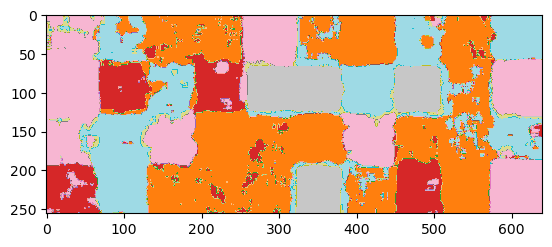

0.225


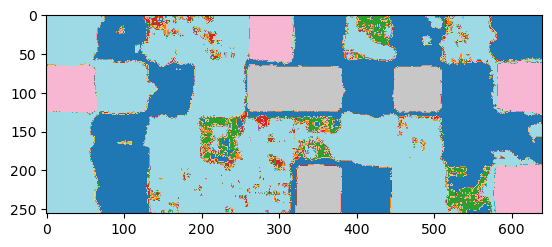

0.2025


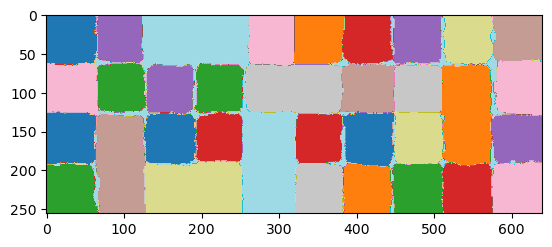

0.18225000000000002


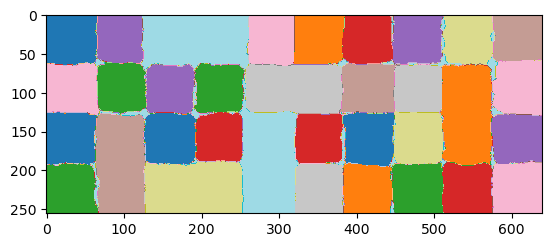

0.16402500000000003


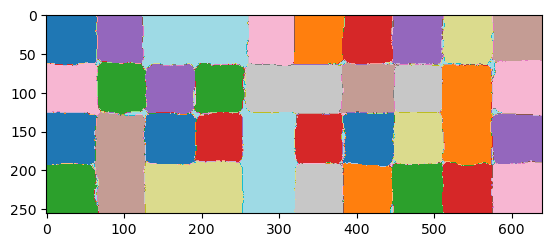

0.14762250000000005


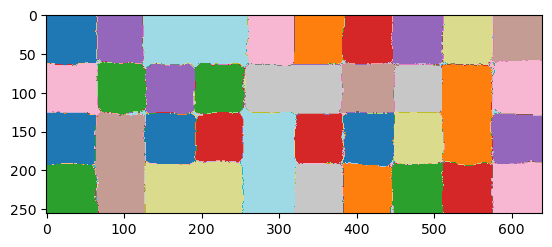

0.13286025000000004


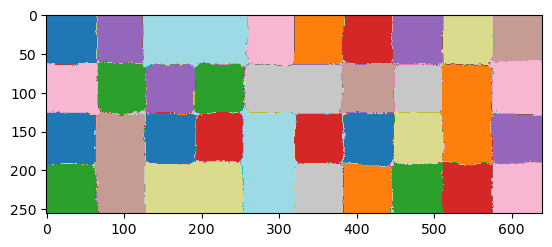

0.11957422500000003


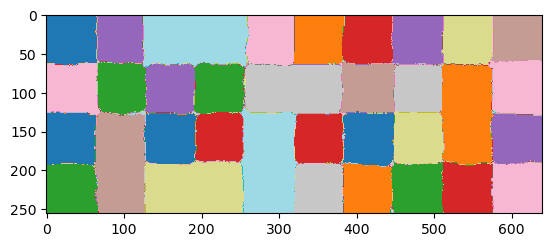

0.10761680250000004


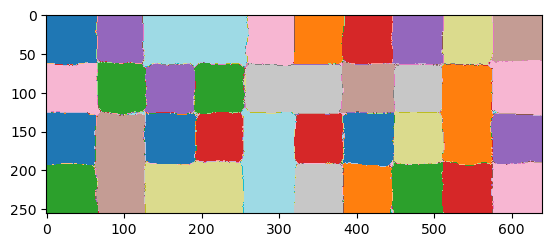

0.09685512225000004


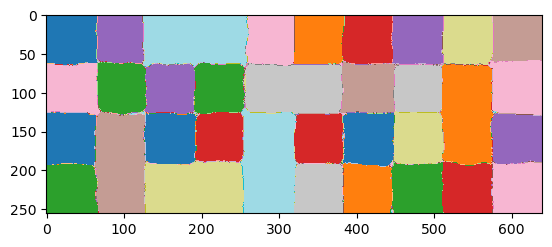

0.08716961002500004


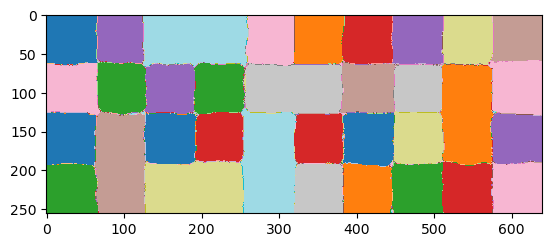

0.07845264902250004


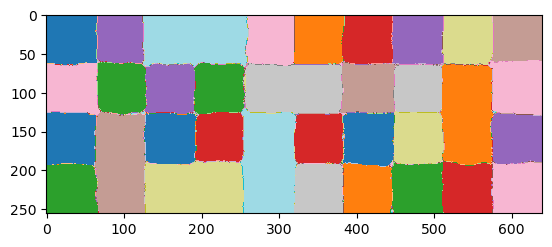

0.07060738412025004


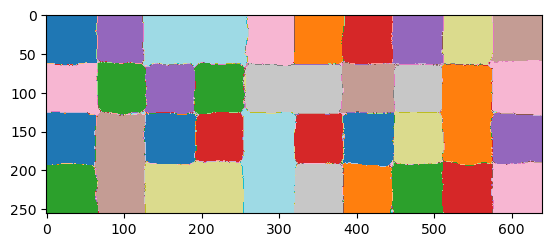

0.06354664570822503


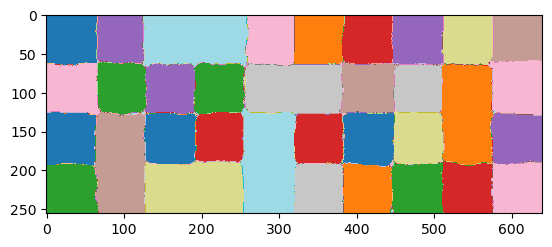

0.05719198113740253


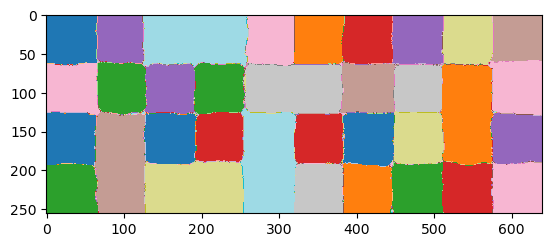

0.051472783023662275


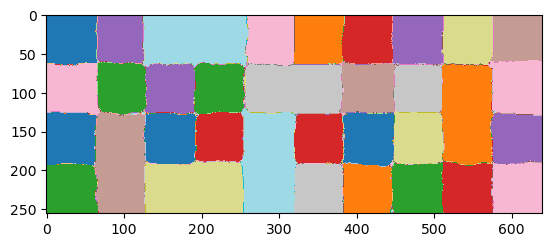

In [45]:
# Clustering at different temperatures
for i in HC.preds:
  print(i[0])
  plt.imshow(i[1], cmap="tab20")
  plt.show()

Observation: The lower the temperature, the more clusters we assign.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.